# Latent Diffusion Models (LDMs)

**Goals for this notebook**

1. Define and derive Latent Diffusion Models (LDMs).
2. Explain the key concepts: latent space, diffusion in latent space, and reconstruction.
3. Perform computations step by step and print explanations.
4. Visualize data in 2D/3D using PCA to understand latent trajectories.
5. Cover a practical example using MNIST for simplicity.
6. Highlight use cases, e.g., conditional image generation and memory-efficient diffusion.


# Definition and Derivation of Latent Diffusion Models

Latent Diffusion Models (LDMs) are **diffusion models applied in a compressed latent space** rather than pixel space to improve efficiency.

**Step 1: Encode data into latent space**
$$
z = E(x), \quad x \in \mathbb{R}^{H\times W \times C}, \quad z \in \mathbb{R}^{h \times w \times c}
$$
where $E$ is an encoder (e.g., from a VAE) and $h \ll H, w \ll W$.

**Step 2: Forward diffusion in latent space**
$$
q(z_t \mid z_0) = \mathcal{N}(z_t; \sqrt{\bar{\alpha}_t} z_0, (1-\bar{\alpha}_t) I)
$$
with $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$ and $\alpha_s = 1-\beta_s$.

**Step 3: Reverse process (noise prediction)**
Instead of predicting $z_0$ directly, the network predicts noise:
$$
\epsilon_\theta(z_t, t) \approx \epsilon_t
$$
Reconstruction of the original latent:
$$
\hat z_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \big( z_t - \sqrt{1-\bar{\alpha}_t} \epsilon_\theta(z_t, t) \big)
$$

**Step 4: Decode back to image space**
$$
\hat x_0 = D(\hat z_0), \quad D \text{ is the decoder of the VAE}
$$

**Advantages:**
- Smaller latent space → faster training and sampling.
- Memory-efficient.
- Can condition on text, class labels, or other modalities.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_test = datasets.MNIST(root="mnist_data", train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist_test, batch_size=8, shuffle=False)

imgs, labels = next(iter(loader))
imgs = imgs.to(device)
print("Batch shape:", imgs.shape)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


Batch shape: torch.Size([8, 1, 28, 28])


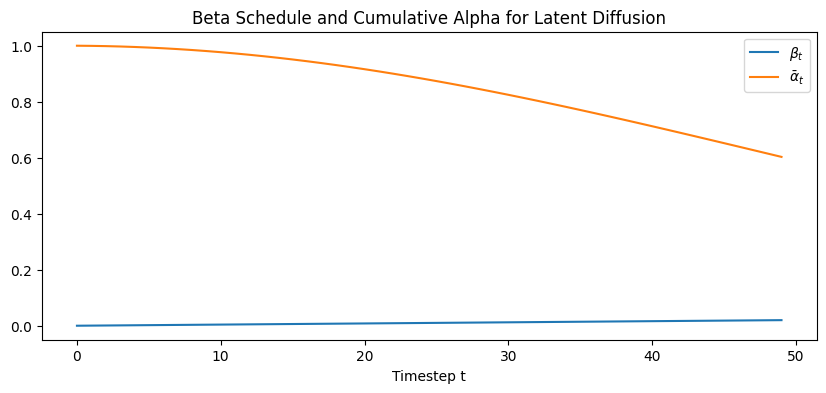

In [3]:
T = 50
beta_start, beta_end = 0.0001, 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

plt.figure(figsize=(10,4))
plt.plot(betas.cpu(), label=r'$\beta_t$')
plt.plot(alpha_bars.cpu(), label=r'$\bar\alpha_t$')
plt.xlabel("Timestep t")
plt.title("Beta Schedule and Cumulative Alpha for Latent Diffusion")
plt.legend()
plt.show()


In [4]:
latent_dim = 16  # small latent for demonstration

class SimpleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, latent_dim)
    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))

class SimpleDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 28*28)
    def forward(self, z):
        return self.fc(z).view(z.size(0),1,28,28)

encoder = SimpleEncoder().to(device)
decoder = SimpleDecoder().to(device)

z = encoder(imgs)
print("Latent z shape:", z.shape)


Latent z shape: torch.Size([8, 16])


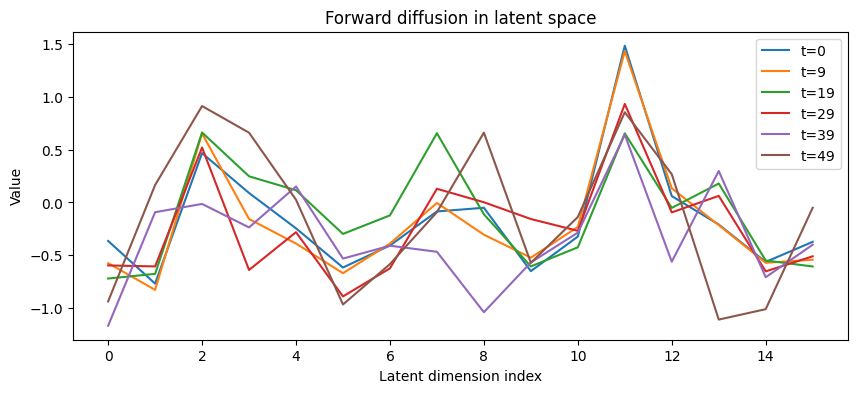

In [5]:
def q_sample_latent(z0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(z0)
    sqrt_ab = torch.sqrt(alpha_bars[t]).view(1,1).to(z0.device)
    sqrt_1_ab = torch.sqrt(1-alpha_bars[t]).view(1,1).to(z0.device)
    return sqrt_ab*z0 + sqrt_1_ab*noise, noise

t_viz = [0, 9, 19, 29, 39, 49]
noisy_latents = []

for t in t_viz:
    z_t, eps = q_sample_latent(z[0:1], t)
    noisy_latents.append((t, z_t.cpu().detach().numpy().flatten()))

# visualize latent trajectories
plt.figure(figsize=(10,4))
for t, vec in noisy_latents:
    plt.plot(vec, label=f't={t}')
plt.title("Forward diffusion in latent space")
plt.xlabel("Latent dimension index")
plt.ylabel("Value")
plt.legend()
plt.show()


In [6]:
class LatentNoisePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    def forward(self, z_t, t=None):
        return self.net(z_t)

noise_predictor = LatentNoisePredictor().to(device)
noise_predictor.eval()

# demo reconstruction
t_demo = 20
z_t, true_eps = q_sample_latent(z[0:1], t_demo)
pred_eps = noise_predictor(z_t)

z0_hat = (z_t - torch.sqrt(1-alpha_bars[t_demo])*pred_eps)/torch.sqrt(alpha_bars[t_demo])
x0_hat = decoder(z0_hat)

print("z_t mean/std:", z_t.mean().item(), z_t.std().item())
print("z0_hat mean/std:", z0_hat.mean().item(), z0_hat.std().item())


z_t mean/std: -0.07598289102315903 0.6643443703651428
z0_hat mean/std: -0.09190748631954193 0.7100553512573242


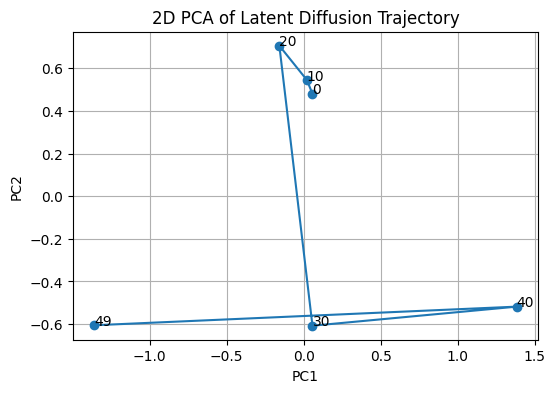

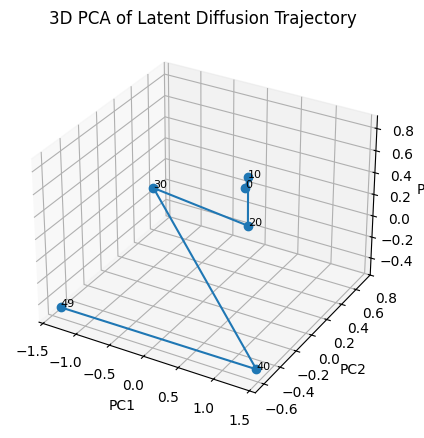

In [8]:
# PCA of latent trajectory
steps_demo = [0, 10, 20, 30, 40, 49]
vecs = []
for t in steps_demo:
    z_t, _ = q_sample_latent(z[0:1], t)

    # FIX: detach before converting to NumPy
    vecs.append(z_t.detach().cpu().numpy().flatten())

vecs = np.stack(vecs)

pca = PCA(n_components=3)
proj = pca.fit_transform(vecs)

# 2D plot
plt.figure(figsize=(6,4))
plt.plot(proj[:,0], proj[:,1], marker='o')
for i, (x,y,z) in enumerate(proj):
    plt.text(x, y, str(steps_demo[i]))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA of Latent Diffusion Trajectory")
plt.grid(True)
plt.show()

# 3D plot
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(proj[:,0], proj[:,1], proj[:,2], marker='o')
for i, (x,y,z) in enumerate(proj):
    ax.text(x, y, z, str(steps_demo[i]), size=8)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA of Latent Diffusion Trajectory")
plt.show()


# Summary and Use Cases

1. Latent Diffusion Models perform diffusion in a compressed latent space instead of pixel space.
2. Forward diffusion: $q(z_t \mid z_0) = \mathcal{N}(z_t; \sqrt{\bar\alpha_t} z_0, (1-\bar\alpha_t) I)$.
3. Noise predictor $\epsilon_\theta(z_t, t)$ allows reconstruction:
   $$
   \hat z_0 = \frac{z_t - \sqrt{1-\bar\alpha_t} \epsilon_\theta(z_t, t)}{\sqrt{\bar\alpha_t}}, \quad \hat x_0 = D(\hat z_0)
   $$
4. Advantages:
   - Faster training due to smaller latent space.
   - Memory-efficient.
   - Can extend to conditional generation (text, class labels).
5. Visualizations demonstrate latent trajectories and the effect of noise subtraction.
